In [63]:
%%capture
%pylab inline --no-import-all
import math 
import utils
import matplotlib.pyplot as plt

#utils.set_default_plot_size()

In [41]:
from QuantLib import *

In [42]:
today = Date(31, October, 2017)
Settings.instance().evaluationDate = today


In [43]:
# input 3 1-day cash deposit rate
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)), 
                              Period(1,Days), fixingDays, TARGET(), 
                              Following, False, Actual360()) 
           for rate, fixingDays in [(1.07, 0), (1.07, 1), (1.07, 2)] ]


In [44]:
eonia = Eonia()

In [10]:
#  five OIS forwards on ECB dates
#helpers += [ DatedOISRateHelper(start_date, end_date, QuoteHandle(SimpleQuote(rate/100)), eonia) 
             #for rate, start_date, end_date in [ 
                 #(0.046, Date(16,January,2013), Date(13,February,2013)), 
                 #(0.016, Date(13,February,2013), Date(13,March,2013)), 
                 #(-0.007, Date(13,March,2013), Date(10,April,2013)), 
                 #(-0.013, Date(10,April,2013), Date(8,May,2013)), 
                 #(-0.014, Date(8,May,2013), Date(12,June,2013))] ]


In [102]:
# OIS tenors to 30 years
helpers += [ OISRateHelper(2, Period(*tenor), QuoteHandle(SimpleQuote(rate/100)), eonia) 
            for rate, tenor in [( 1.16, ( 1, Weeks)),( 1.16, ( 2, Weeks)),
                                ( 1.161, ( 3, Weeks)),( 1.1586, ( 1, Months)),
                                ( 1.2215, ( 2, Months)),( 1.273, ( 3, Months)),
                                ( 1.3, ( 4, Months)),( 1.325, ( 5, Months)),
                                ( 1.355, ( 6, Months)),( 1.425, ( 9, Months)),
                                ( 1.479, ( 12, Months)),( 1.558, ( 18, Months)),
                                ( 1.622, ( 2, Years)),( 1.711, ( 3, Years)),
                                ( 1.783, ( 4, Years)),( 1.841, ( 5, Years)),
                                ( 2.2117, ( 7, Years)),( 2.3511, ( 10, Years)),
                                ( 2.4215, ( 12, Years)),( 2.4923, ( 15, Years)),
                                ( 2.559, ( 20, Years)),( 2.5844, ( 25, Years)),
                                ( 2.5908, ( 30, Years)),( 2.577, ( 40, Years)),
                                ( 2.546, ( 50, Years)),] ]

In [105]:
###### explore and fix turn-of-year jumps begin
eonia_curve_c = PiecewiseLogCubicDiscount(0, TARGET(), helpers, Actual365Fixed()) 
eonia_curve_c.enableExtrapolation()


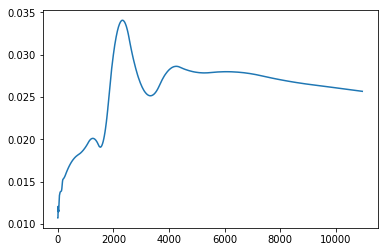

In [84]:
today = eonia_curve_c.referenceDate() 
end = today + Period(30,Years) 
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ] 
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
#utils.plot_curve(plt, dates, [(rates_c,'-')])
plt.plot(rates_c)

In [85]:
eonia_curve_ff = PiecewiseFlatForward(0, TARGET(), helpers, Actual365Fixed())
eonia_curve_ff.enableExtrapolation()

In [92]:
end = today + Period(12*30,Months) 
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
rates_ff = [ eonia_curve_ff.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

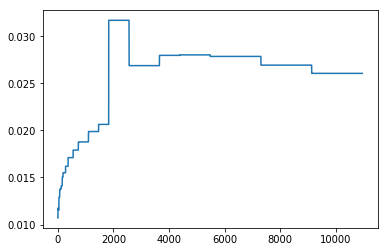

In [94]:
#utils.plot_curve(plt, dates, [(rates_ff,'-')])
plt.plot(rates_ff)

In [67]:
nodes = list(eonia_curve_ff.nodes())

In [72]:
nodes[:9]

[(Date(31,10,2017), 0.010848449891868662),
 (Date(1,11,2017), 0.010848449891868662),
 (Date(2,11,2017), 0.010848449891979372),
 (Date(3,11,2017), 0.010848449891979372),
 (Date(9,11,2017), 0.011911674089641966),
 (Date(16,11,2017), 0.011757133330836656),
 (Date(23,11,2017), 0.011784879028367912),
 (Date(4,12,2017), 0.011690483732436481),
 (Date(2,1,2018), 0.013068109609927119)]

In [22]:
# need to customize based on the location of the jumps
#nodes[6] = (nodes[6][0], (nodes[5][1]+nodes[7][1])/2.0)
#nodes[:9]

NameError: name 'nodes' is not defined

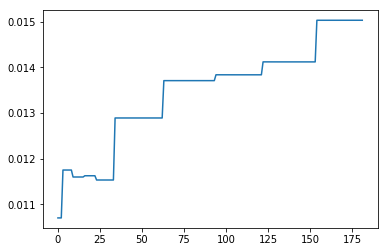

In [75]:
## I didn't find a jump
#temp_dates, temp_rates = zip(*nodes) 
#temp_curve = ForwardCurve(temp_dates, temp_rates, eonia_curve_ff.dayCounter())
#temp_rates = [ temp_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
#utils.plot_curve(plt, dates, [(temp_rates,'-'), (rates_ff,'--')])
#plt.plot(temp_rates)

In [24]:
#d1 = Date(31,December,2012) - Period(1,Weeks)
#d2 = Date(31,December,2012) + Period(1,Weeks)

In [25]:
#F = eonia_curve_ff.forwardRate(d1, d2, Actual360(), Simple).rate()
#F_1 = temp_curve.forwardRate(d1, d2, Actual360(), Simple).rate() 
#print utils.format_rate(F,digits=3), utils.format_rate(F_1,digits=3)

SyntaxError: invalid syntax (<ipython-input-25-01618780c0d3>, line 3)

In [77]:
t12 = eonia_curve_ff.dayCounter().yearFraction(d1,d2)
t_j = eonia_curve_ff.dayCounter().yearFraction(Date(31,December,2012), Date(2,January,2013))
J = (F-F_1)*t12/t_j
#print utils.format_rate(J,digits=3)

NameError: name 'F' is not defined

In [30]:
B = 1.0/(1.0+J*t_j)
jumps = [QuoteHandle(SimpleQuote(B))]
jump_dates = [Date(31,December,2012)]
eonia_curve_j = PiecewiseFlatForward(0, TARGET(), helpers, Actual365Fixed(), jumps, jump_dates)


NameError: name 'J' is not defined

In [31]:
rates_j = [ eonia_curve_j.forwardRate(d, TARGET().advance(d,1,Days), 
                                      Actual360(), Simple).rate() for d in dates ]
utils.plot_curve(plt, dates, [(rates_ff,'-'), (rates_j,'o')])

NameError: name 'eonia_curve_j' is not defined

In [32]:
dates = [ today+Period(i,Days) for i in range(0, 365*2+1) ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
utils.plot_curve(plt, dates, [(rates,'.')], ymin=-0.001, ymax=0.002)

NameError: name 'eonia_curve' is not defined

In [37]:
dates = [ today+Period(i,Months) for i in range(0, 12*60+1) ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
utils.plot_curve(plt, dates, [(rates,'-')], ymin=0.0, ymax=0.035)
###### explore and fix turn-of-year jumps end

NameError: name 'eonia_curve' is not defined

In [38]:
############# if the jumps have been located
jumps = [QuoteHandle(SimpleQuote(math.exp(-J*2.0/360))) for J in [0.00102, 0.00086]]
jump_dates = [Date(31,December,2012), Date(31,December,2013)]
eonia_curve = PiecewiseLogCubicDiscount(2, TARGET(), helpers, Actual365Fixed(), jumps, jump_dates)
eonia_curve.enableExtrapolation()
